In [ ]:
# ! pip install torch==2.4.1 torchvision==0.19.0
# ! pip install accelerate==0.34.2
# ! pip install transformers==4.45.1
# ! pip install unsloth==2024.9.post3
! pip install bitsandbytes==0.44.0

In [1]:
%env CUDA_VISIBLE_DEVICES=0,1
%env TOKENIZERS_PARALLELISM=false

env: CUDA_VISIBLE_DEVICES=0,1
env: TOKENIZERS_PARALLELISM=false


In [2]:
BASE_PATH = "/kaggle/input"
# MODEL_ID = f"unsloth/Meta-Llama-3.1-8B-bnb-4bit"
MODEL_ID = "unsloth/Llama-3.2-3B-Instruct-bnb-4bit"
# VLLM_MODEL_ID = "unsloth/Llama-3.2-11B-Vision-Instruct"
VLLM_MODEL_ID = "4bit/Qwen2-VL-7B-Instruct"
MAX_NEW_TOKENS = 2048
MAX_SEQ_LENGTH = 32768 - MAX_NEW_TOKENS

In [3]:
import sys

# sys.path.append(BASE_PATH)
# sys.path.append(f"{BASE_PATH}/scripts")
sys.path.append('/kaggle/input/arc-agi-python-utilities')

In [4]:
import json

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal

from transformers import AutoTokenizer, AutoModelForCausalLM, AutoConfig, BitsAndBytesConfig  # type: ignore
from transformers import MllamaForConditionalGeneration, Qwen2VLForConditionalGeneration, AutoProcessor

from tqdm.auto import tqdm  # type: ignore

import data_utils # type: ignore

In [5]:
dtype = torch.bfloat16

In [6]:
def get_models():    
    tokenizer = AutoTokenizer.from_pretrained(MODEL_ID, padding_side="left")
    llm_model = AutoModelForCausalLM.from_pretrained(
        MODEL_ID,
        torch_dtype=dtype,
        device_map="auto",
        max_memory = {0: "15GiB", "cpu": "16GiB"},
#         flash_attention_2=True,
        output_hidden_states=True,
        return_dict_in_generate=True,
        quantization_config=BitsAndBytesConfig(load_in_4bit=True)
    )
    
    processor = AutoProcessor.from_pretrained(VLLM_MODEL_ID)
    vllm_model = Qwen2VLForConditionalGeneration.from_pretrained(
        VLLM_MODEL_ID,
        torch_dtype=dtype,
        device_map="auto",
        max_memory = {1: "15GiB", "cpu": "16GiB"},
#         flash_attention_2=True,
        output_hidden_states=True,
        return_dict_in_generate=True,
        quantization_config=BitsAndBytesConfig(load_in_4bit=True)
    )

    return {
        'llm': llm_model,
        'tokenizer': tokenizer,
        'vllm': vllm_model,
        'processor': processor
    }


In [7]:
models = get_models()

Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.
/opt/conda/lib/python3.10/site-packages/transformers/quantizers/auto.py:182: UserWarning: You passed `quantization_config` or equivalent parameters to `from_pretrained` but the model you're loading already has a `quantization_config` attribute. The `quantization_config` from the model will be used.
  warnings.warn(warning_msg)
Unrecognized keys in `rope_scaling` for 'rope_type'='default': {'mrope_section'}
`Qwen2VLRotaryEmbedding` can now be fully parameterized by passing the model config through the `config` argument. All other arguments will be removed in v4.46


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

In [8]:
dataset = data_utils.prepare_dataset(models['tokenizer'], fit_dataset=False, base_path=BASE_PATH, final_training=False, prepare_inputs_func=data_utils.prepare_inputs)
dataset

Map:   0%|          | 0/105 [00:00<?, ? examples/s]

Map:   0%|          | 0/416 [00:00<?, ? examples/s]

Map:   0%|          | 0/419 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'challenge', 'solution', 'texts', 'messages'],
        num_rows: 416
    })
    test: Dataset({
        features: ['id', 'challenge', 'solution', 'texts', 'messages'],
        num_rows: 293
    })
    val: Dataset({
        features: ['id', 'challenge', 'solution', 'texts', 'messages'],
        num_rows: 126
    })
    predict: Dataset({
        features: ['id', 'challenge', 'texts', 'messages'],
        num_rows: 105
    })
})

In [9]:
dataset['train'][0]['challenge']['test']['input']

[[7, 0, 7], [7, 0, 7], [7, 7, 0]]

In [10]:
def eval(f):
    def wrapper(model, *args, **kwargs):
        if hasattr(model, 'to_inference'):
            model.to_inference()
        else:
            model.eval()
        with torch.no_grad():
            return f(model, *args, **kwargs)

    return wrapper


def train(f):
    def wrapper(model, *args, **kwargs):
        if hasattr(model, 'to_training'):
            model.to_training()
        else:
            model.train()
        return f(model, *args, **kwargs)

    return wrapper


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [11]:
@eval
def describe_puzzle(model, processor, image, prompt):
    # Create prompt
    messages = [
        {
            "role": "user",
            "content": [
                {"type": "image"},
                {"type": "text", "text": prompt},
            ],
        },
    ]

    text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    inputs = processor(text=[text], images=[image], return_tensors="pt")
    inputs = inputs.to(model.device)

    # Run inference
    generated_ids = model.generate(**inputs, max_new_tokens=128)
    generated_ids = generated_ids[0, inputs.input_ids.shape[1]:]
    generated_text = processor.decode(generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)
    return generated_text

In [12]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

def list_to_image(integer_list_2d, target_size=30):
    # Convert the 2D list to a NumPy array
    array = np.array(integer_list_2d)
    
    # Get the unique values in the array
    unique_values = np.unique(array)
    
    # Create a colormap
    cmap = plt.get_cmap('tab10')
    
    # Create a color lookup dictionary
    color_lookup = {value: cmap(i % 10)[:3] for i, value in enumerate(unique_values)}
    
    # Create an RGB array
    rgb_array = np.array([[color_lookup[val] for val in row] for row in array])
    
    # Convert to 8-bit color values
    rgb_array = (rgb_array * 255).astype(np.uint8)
    
    # Create an image from the colored array
    image = Image.fromarray(rgb_array, mode='RGB')
    
    # Create a new blank image with the target size
    new_image = Image.new('RGB', (target_size, target_size), color=(0, 0, 0))
    
    # Paste the original image onto the new image
    new_image.paste(image, (0, 0))
    
    new_image = new_image.resize((target_size * 15, target_size * 15), Image.NEAREST)
    
    return new_image

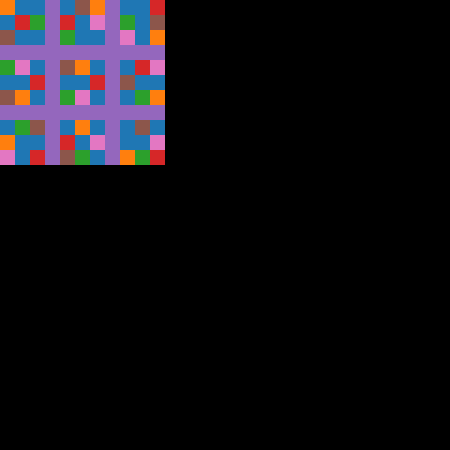

In [13]:
image = list_to_image(dataset['train'][10]['challenge']['train'][0]['input'])
image

In [29]:
# describe_puzzle(models['vllm'], models['processor'], image, "Describe the image")

In [53]:
class Encoder(nn.Module):
    def __init__(self, input_dim, condition_dim, latent_dim, hidden_dim):
        super(Encoder, self).__init__()
        self.condition_dim = condition_dim
        
        self.query = nn.Linear(input_dim, hidden_dim, dtype=dtype)
        self.key = nn.Linear(input_dim, hidden_dim, dtype=dtype)
        self.value = nn.Linear(input_dim, hidden_dim, dtype=dtype)
        
        self.attention = nn.MultiheadAttention(hidden_dim, num_heads=4, dtype=dtype)
        
        self.fc1 = nn.Linear(hidden_dim, hidden_dim, dtype=dtype)

        self.fc_mu = nn.Linear(hidden_dim, latent_dim, dtype=dtype)      # Mean of the latent space
        self.fc_var = nn.Linear(hidden_dim, latent_dim, dtype=dtype)     # Variance of the latent space

    def forward(self, x, condition):
        # Add the condition to the input
        x_cond = torch.cat([x, condition], dim=1)

        # Apply attention
        attn_output, _ = self.attention(self.query(x_cond), self.key(x_cond), self.value(x_cond))
        h = F.relu(self.fc1(attn_output.mean(dim=1)))  # Reduce to a single representation per sample

        # Compute the mean and variance for the latent space
        mu = self.fc_mu(h)
        log_var = self.fc_var(h)

        return mu, log_var

In [54]:
def reparameterize(mu, log_var):
    std = torch.exp(0.5 * log_var)
    eps = torch.randn_like(std)
    return mu + eps * std

In [66]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, condition_dim, output_dim, hidden_dim):
        super(Decoder, self).__init__()
        self.condition_dim = condition_dim
        self.fc1 = nn.Linear(latent_dim + condition_dim, hidden_dim, dtype=dtype)
        
        self.query = nn.Linear(hidden_dim, hidden_dim, dtype=dtype)
        self.key = nn.Linear(hidden_dim, hidden_dim, dtype=dtype)
        self.value = nn.Linear(hidden_dim, hidden_dim, dtype=dtype)

        self.attention = nn.MultiheadAttention(hidden_dim, num_heads=4, dtype=dtype)
        self.fc_output = nn.Linear(hidden_dim, output_dim, dtype=dtype)

    def forward(self, z, condition, output_len):
        # Combine latent variable z and condition
        z_cond = torch.cat([z.unsqueeze(1).repeat(1, condition.shape[1], 1), condition], dim=-1)

        h = F.relu(self.fc1(z_cond))
        
        # Apply attention to guide the generation process
        attn_output, _ = self.attention(self.query(h), self.key(h), self.value(h))

        # Generate output
        output = torch.sigmoid(self.fc_output(attn_output))

        return output

In [67]:
class CVAE(nn.Module):
    def __init__(self, input_dim, condition_dim, latent_dim, output_dim, hidden_dim):
        super(CVAE, self).__init__()
        self.encoder = Encoder(input_dim, condition_dim, latent_dim, hidden_dim)
        self.decoder = Decoder(latent_dim, condition_dim, output_dim, hidden_dim)

    def forward(self, x, condition, output_len):
        # Encode
        mu, log_var = self.encoder(x, condition)
        
        # Reparameterization trick
        z = reparameterize(mu, log_var) # (B, latent_dim)

        # Decode
        output = self.decoder(z, condition, output_len)

        return output, mu, log_var

In [83]:
class ARCModel(torch.nn.Module):
    def __init__(self, llm_model, vllm_model):
        super().__init__()
        self.llm_model = llm_model
        self.vllm_model = vllm_model
        
        self.text_proj = nn.Linear(3072, 2304, dtype=dtype)
        self.image_proj = nn.Linear(3584, 2304, dtype=dtype)
        
        self.output_dim = 30
        
        self.cvae = CVAE(input_dim=2304, condition_dim=2304, latent_dim=512, output_dim=self.output_dim, hidden_dim=1024)

    def to(self, device):
        self.device = device
        self.cvae.to(device)
        self.text_proj.to(device)
        self.image_proj.to(device)
        return self

    def to_inference(self):
        self.llm_model.eval()
        self.vllm_model.eval()

    def to_training(self):
        self.llm_model.train()
        self.vllm_model.train()
        
    def cvae_loss(self,recon_x, x, mu, log_var):
        recon_loss = F.binary_cross_entropy(recon_x, x, reduction='sum') # TODO: try BCELoss
        # KL Divergence loss
        kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        return recon_loss + kl_loss
    
    def encode(self, text_inputs, image_inputs):
        with torch.no_grad():
            text_features = self.llm_model(**text_inputs.to(self.llm_model.device)).hidden_states[-1] # (batch_size, seq_len, 3072)
            image_features = self.vllm_model(**image_inputs.to(self.vllm_model.device)).hidden_states[-1] # (batch_size, vid_len, 3584)
        
        # -- todo: cleanup
        text_inputs.to('cpu')
        image_inputs.to('cpu')
        
        torch.cuda.empty_cache()
        # -- todo: cleanup
        
        text_features = self.text_proj(text_features.to(self.device))
        image_features = self.image_proj(image_features.to(self.device))
        
        features = torch.cat([text_features, image_features], dim=1) # (batch_size, seq_len + vid_len, 2304)
        return features

    def forward(self, train_inputs, test_inputs, targets=None):
        train_features = self.encode(text_inputs=train_inputs['text'], image_inputs=train_inputs['image']) # (B, seq_len + vid_len, 2304)
        test_features = self.encode(text_inputs=test_inputs['text'], image_inputs=test_inputs['image']) # (B, seq_len + vid_len, 2304)
        
        outputs, _, _ = self.cvae(train_features, test_features, output_len=30) # (B, cond_seq_len, 30)
        
        # we will only take (B, 30, 30) for the loss calculation
        return outputs[:, :self.output_dim, :]

    def from_pretrained(self, path):
        # self.space_model.load_state_dict(torch.load(f"{path}/space_model.pth"))
        # self.classifier.load_state_dict(torch.load(f"{path}/classifier.pth"))
        # return self
        ...

    def save_pretrained(self, path):
        # self.base_model.save_pretrained(f"{path}/base")
        # torch.save(self.space_model.state_dict(), f"{path}/space_model.pth")
        # torch.save(self.classifier.state_dict(), f"{path}/classifier.pth")
        ...

In [84]:
arc_model = ARCModel(models['llm'], models['vllm'])
arc_model.to('cuda:0')

ARCModel(
  (llm_model): LlamaForCausalLM(
    (model): LlamaModel(
      (embed_tokens): Embedding(128256, 3072)
      (layers): ModuleList(
        (0-27): 28 x LlamaDecoderLayer(
          (self_attn): LlamaSdpaAttention(
            (q_proj): Linear4bit(in_features=3072, out_features=3072, bias=False)
            (k_proj): Linear4bit(in_features=3072, out_features=1024, bias=False)
            (v_proj): Linear4bit(in_features=3072, out_features=1024, bias=False)
            (o_proj): Linear4bit(in_features=3072, out_features=3072, bias=False)
            (rotary_emb): LlamaRotaryEmbedding()
          )
          (mlp): LlamaMLP(
            (gate_proj): Linear4bit(in_features=3072, out_features=8192, bias=False)
            (up_proj): Linear4bit(in_features=3072, out_features=8192, bias=False)
            (down_proj): Linear4bit(in_features=8192, out_features=3072, bias=False)
            (act_fn): SiLU()
          )
          (input_layernorm): LlamaRMSNorm((3072,), eps=1e-05)
   

In [85]:
arc_model.to_inference()

In [26]:
messages = [
        {
            "role": "user",
            "content": [
                {"type": "image"},
                {"type": "text", "text": "Describe the image"},
            ],
        },
    ]

image_features = models['processor'].apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
image_features = models['processor'](text=[image_features], images=[image], return_tensors="pt")

In [86]:
outputs = arc_model(
    train_inputs={
    'text': models['tokenizer'](dataset['train'][0]['texts'], return_tensors='pt'),
    'image': image_features
}, 
test_inputs={
    'text': models['tokenizer'](dataset['train'][0]['texts'], return_tensors='pt'),
    'image': image_features
},
targets=None)

In [ ]:
def train_cvae(model, dataset, optimizer, epochs):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for json_object in dataset:
            optimizer.zero_grad()
            
            # Prepare inputs for the CVAE
            train_features, test_features = prepare_inputs(json_object)
            
            # Forward pass through the CVAE
            generated_output, mu, log_var = model(train_features, test_features)
            
            # Compute loss (reconstruction + KL divergence)
            test_output = extract_llm_features([json_object['test_example']['output']])
            loss = cvae_loss(generated_output, test_output, mu, log_var)
            
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        print(f'Epoch {epoch + 1}, Loss: {total_loss / len(dataset)}')


In [ ]:
# llm - 4096
# vllm - 3584